# RQ1

## Setup

In [1]:
from __future__ import annotations

import colormaps as cmaps
import connectorx  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import opinionated  # noqa: F401
import polars as pl
import rustworkx as rx
import seaborn as sns
from tqdm import tqdm

from rs_graph.db import constants as db_constants

# Setup plotting style
plt.style.use("opinionated_rc")
PALETTE = cmaps.bold._colors.tolist()
sns.set_palette(PALETTE)

# Plotting/Data Selection constants
DEFAULT_TOP_N = 9

/Users/evamaxfield/micromamba/envs/rs-graph/lib/python3.13/site-packages/opinionated/__init__.py:24: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Now downloading: Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight Black
Now downloading: Fira Sans
Added new font as Fira Sans Light
Added new font as Fira Sans
Added new font as Fira Sans
Added new font as Fira Sans Black
Now downloading: Fira Sans Condensed
Added new font as Fira Sans Condensed Light
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed Black
Now downloading: IBM Plex Sans
Added new font as IBM Plex San

In [2]:
def _read_table(table: str) -> pl.DataFrame:
    """Read a table from the v2 database."""
    return pl.read_database_uri(
        f"SELECT * FROM {table}",
        f"sqlite:///{db_constants.V2_DATABASE_PATHS.dev}",
    )


def load_pairs(sample_size: int | None = None) -> pl.DataFrame:
    """Load document-repository pairs with all relevant metadata."""
    # Read all the tables we need
    dataset_sources = _read_table("dataset_source")
    docs = _read_table("document")
    repos = _read_table("repository")
    pairs = _read_table("document_repository_link")
    doc_topics = _read_table("document_topic")
    topics = _read_table("topic")

    # Drop to unique doc and unique repo in pairs
    pairs = pairs.unique(
        subset="document_id",
        keep="none",
    ).unique(
        subset="repository_id",
        keep="none",
    )

    # Apply sampling if requested
    if sample_size is not None:
        sampled_doc_ids = (
            pairs.select("document_id")
            .unique()
            .sample(n=min(sample_size, pairs.height), seed=42)
        )
        pairs = pairs.filter(pl.col("document_id").is_in(sampled_doc_ids["document_id"]))

    # Load contributor/institution data
    doc_contribs = _read_table("document_contributor")
    doc_contrib_institutions = _read_table("document_contributor_institution")
    institutions = _read_table("institution")

    # Process authorship team countries
    doc_author_countries = (
        doc_contribs.select(
            pl.col("id").alias("document_contributor_id"),
            pl.col("researcher_id"),
            pl.col("document_id"),
        )
        .join(
            doc_contrib_institutions.select("document_contributor_id", "institution_id"),
            on="document_contributor_id",
            how="left",
        )
        .join(
            institutions.select(pl.col("id").alias("institution_id"), "country_code"),
            on="institution_id",
            how="left",
        )
        .with_columns(
            pl.when(pl.col("country_code").is_null())
            .then(pl.lit("Unknown"))
            .otherwise(pl.col("country_code"))
        )
        .group_by("document_id")
        .agg(
            pl.len().alias("document_n_authors"),
            pl.when(pl.col("country_code").n_unique() == 1)
            .then(pl.col("country_code").first())
            .otherwise(pl.lit("Multiple")),
        )
        .with_columns(
            pl.when(pl.col("country_code").is_null())
            .then(pl.lit("Unknown"))
            .otherwise(pl.col("country_code"))
            .alias("country_code")
        )
    )

    # Get repo contributors count
    repo_contribs = _read_table("repository_contributor")
    repo_contribs = repo_contribs.group_by("repository_id").len("repository_n_contributors")

    # Get repo file count
    repo_files = _read_table("repository_file")
    repo_file_counts = (
        repo_files.filter(pl.col("tree_type") == "blob")
        .group_by("repository_id")
        .agg(
            pl.len().alias("repository_n_files"),
            pl.col("bytes_of_code").sum().alias("repository_total_file_bytes"),
        )
    )

    # Get repo language breakdown
    repo_languages = _read_table("repository_language")
    repo_language_counts = repo_languages.group_by("repository_id").agg(
        pl.len().alias("repository_n_languages"),
        pl.col("bytes_of_code").sum().alias("repository_total_language_bytes"),
    )

    # Join all tables
    result = (
        pairs.select(
            "document_id",
            "repository_id",
            "dataset_source_id",
            pl.col("predictive_model_confidence").alias("document_repository_link_confidence"),
        )
        .join(
            docs.select(
                pl.col("id").alias("document_id"),
                pl.col("title").alias("document_title"),
                pl.col("doi").alias("document_doi"),
                pl.col("cited_by_count").alias("document_cited_by_count"),
                pl.col("fwci").alias("document_fwci"),
                pl.col("is_open_access").alias("document_is_open_access"),
                pl.col("publication_date").alias("document_publication_date"),
                pl.col("document_type").alias("document_type"),
            ),
            on="document_id",
            how="left",
        )
        .join(
            repos.select(
                pl.col("id").alias("repository_id"),
                pl.col("owner").alias("repository_owner"),
                pl.col("name").alias("repository_name"),
                pl.col("stargazers_count").alias("repository_stargazers_count"),
                pl.col("commits_count").alias("repository_commits_count"),
                pl.col("primary_language").alias("repository_primary_language"),
                pl.col("size_kb").alias("repository_size_kb"),
                pl.col("forks_count").alias("repository_forks_count"),
                pl.col("open_issues_count").alias("repository_open_issues_count"),
                pl.col("watchers_count").alias("repository_watchers_count"),
                pl.col("is_fork").alias("repository_is_fork"),
                pl.col("license").alias("repository_license"),
                pl.col("creation_datetime").alias("repository_creation_datetime"),
                pl.col("last_pushed_datetime").alias("repository_last_pushed_datetime"),
            ),
            on="repository_id",
            how="left",
        )
        .join(
            dataset_sources.select(
                pl.col("id").alias("dataset_source_id"),
                pl.col("name").alias("dataset_source_name"),
            ),
            on="dataset_source_id",
            how="left",
        )
        .join(
            doc_topics.sort("score", descending=True)
            .unique("document_id", maintain_order=True)
            .select("document_id", pl.col("topic_id")),
            on="document_id",
            how="left",
        )
        .join(
            topics.select(
                pl.col("id").alias("topic_id"),
                pl.col("domain_name").alias("document_domain_name"),
                pl.col("field_name").alias("document_field_name"),
            ),
            on="topic_id",
            how="left",
        )
        .join(doc_author_countries, on="document_id", how="left")
        .join(repo_contribs, on="repository_id", how="left")
        .join(repo_file_counts, on="repository_id", how="left")
        .join(repo_language_counts, on="repository_id", how="left")
        .with_columns(
            pl.col("document_publication_date").dt.year().alias("document_publication_year"),
            (
                (
                    pl.col("repository_last_pushed_datetime")
                    - pl.col("repository_creation_datetime")
                ).dt.total_days()
            ).alias("repository_commit_duration_days"),
        )
    )

    # Calculate field-year-type normalized stargazer count (FWSI)
    # First, determine the expected stars for each field-year-type combination
    field_year_type_expected_stars = result.group_by(
        [
            "document_field_name",
            "document_publication_year",
            "document_type",
        ]
    ).agg(
        pl.col("repository_stargazers_count").mean().alias("expected_stars"),
    )

    # Join back to result
    result = result.join(
        field_year_type_expected_stars,
        on=["document_field_name", "document_publication_year", "document_type"],
        how="left",
    )

    # Calculate FWSI (Field-Weighted Star Impact)
    result = result.with_columns(
        pl.when(pl.col("expected_stars").is_not_null())
        .then(pl.col("repository_stargazers_count") / pl.col("expected_stars"))
        .otherwise(pl.lit(None))
        .alias("repository_fwsi")
    ).drop("expected_stars")

    return result


pairs = load_pairs()
pairs

document_id,repository_id,dataset_source_id,document_repository_link_confidence,document_title,document_doi,document_cited_by_count,document_fwci,document_is_open_access,document_publication_date,document_type,repository_owner,repository_name,repository_stargazers_count,repository_commits_count,repository_primary_language,repository_size_kb,repository_forks_count,repository_open_issues_count,repository_watchers_count,repository_is_fork,repository_license,repository_creation_datetime,repository_last_pushed_datetime,dataset_source_name,topic_id,document_domain_name,document_field_name,document_n_authors,country_code,repository_n_contributors,repository_n_files,repository_total_file_bytes,repository_n_languages,repository_total_language_bytes,document_publication_year,repository_commit_duration_days,repository_fwsi
i64,i64,i64,f64,str,str,i64,f64,bool,date,str,str,str,i64,i64,str,i64,i64,i64,i64,bool,str,datetime[ns],datetime[ns],str,i64,str,str,u32,str,u32,u32,i64,u32,i64,i32,i64,f64
1,1,1,null,"""IBBI: A Python package for the…","""10.21105/joss.08796""",0,0.0,true,2025-12-21,"""article""","""christophermarais""","""ibbi""",3,35,"""Python""",84633,0,4,3,false,"""MIT License""",2025-05-22 15:42:12,2025-12-20 21:55:57,"""joss""",1,"""Physical Sciences""","""Environmental Science""",4,"""US""",1,70,1069482,3,190338,2025,212,0.576642
2,2,1,null,"""Scikit-Topt: A Python Library …","""10.21105/joss.09092""",0,0.0,true,2025-12-26,"""article""","""kevin-tofu""","""scikit-topt""",6,694,"""Python""",19307,3,0,6,false,"""Apache License 2.0""",2025-03-30 23:16:39,2025-12-27 03:02:16,"""joss""",4,"""Physical Sciences""","""Engineering""",1,"""JP""",2,85,663538,2,348909,2025,271,0.292556
3,3,1,null,"""ATAS - Academic Text Analysis …","""10.21105/joss.08599""",0,null,true,2026-01-07,"""article""","""alideschimin""","""sata""",1,100,"""Python""",16537,1,0,1,false,"""GNU General Public License v3.…",2025-02-12 13:56:45,2025-12-05 14:52:32,"""joss""",7,"""Physical Sciences""","""Computer Science""",1,"""BR""",2,56,18590675,4,74157,2026,296,0.222222
4,4,1,null,"""Ziplign: a simple-to-use inter…","""10.21105/joss.09004""",0,0.0,true,2025-12-22,"""article""","""martinghunt""","""ziplign""",19,224,"""GDScript""",21170,1,18,19,false,"""MIT License""",2024-06-10 07:01:58,2025-12-19 14:03:48,"""joss""",10,"""Life Sciences""","""Biochemistry, Genetics and Mol…",6,"""Multiple""",2,177,11046303,2,154562,2025,557,5.614607
5,5,1,null,"""TranCIT: Transient Causal Inte…","""10.21105/joss.09302""",0,0.0,true,2025-12-30,"""article""","""cmc-lab""","""trancit""",3,272,"""Python""",4938,0,1,3,false,"""BSD 2-Clause ""Simplified"" Lice…",2025-03-21 22:58:29,2025-12-31 10:32:44,"""joss""",13,"""Physical Sciences""","""Computer Science""",5,"""Multiple""",3,107,5874679,3,360199,2025,284,0.051159
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
150369,147852,4,null,"""Modelling the mechanics of exp…","""10.1371/journal.pcbi.1006635""",68,5.32575,true,2019-07-05,"""article""","""janeloveless""","""mechanics-of-exploration""",4,7,"""Fortran""",38426,2,0,4,false,"""The Unlicense""",2017-10-13 15:30:50,2018-09-22 13:29:18,"""plos""",805,"""Life Sciences""","""Neuroscience""",4,"""GB""",1,63,42833604,2,444081,2019,343,0.234004
150370,147853,4,null,"""Using smartphone-GPS data to q…","""10.1371/journal.pcbi.1010725""",26,3.55297,true,2022-12-15,"""article""","""afilazzola""","""cuerecreationecology""",1,52,"""HTML""",134304,0,0,1,false,"""MIT License""",2021-05-03 18:08:00,2022-11-08 15:57:37,"""plos""",406,"""Physical Sciences""","""Environmental Science""",10,"""Multiple""",1,453,221161062,4,15372086,2022,553,0.039563
150371,147854,4,null,"""Unsupervised deep learning sup…","""10.1371/journal.pone.0269544""",10,1.237918,true,2022-07-14,"""article""","""ashmikuz""","""sign2vec_d""",4,5,"""Python""",53906,0,0,4,false,"""Other""",2022-05-26 12:44:46,2022-05-26 16:40:33,"""plos""",235,"""Physical Sciences""","""Computer Science""",4,"""Multiple""",1

## Descriptive Stats

shape: (26, 2)
┌─────────────────────────────────┬───────┐
│ document_field_name             ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ Computer Science                ┆ 81126 │
│ Engineering                     ┆ 13681 │
│ Physics and Astronomy           ┆ 5772  │
│ Medicine                        ┆ 4859  │
│ Biochemistry, Genetics and Mol… ┆ 4798  │
│ …                               ┆ …     │
│ Dentistry                       ┆ 52    │
│ Pharmacology, Toxicology and P… ┆ 38    │
│ Chemical Engineering            ┆ 32    │
│ Veterinary                      ┆ 29    │
│ Nursing                         ┆ 28    │
└─────────────────────────────────┴───────┘


<Axes: xlabel='count', ylabel='document_field_name'>

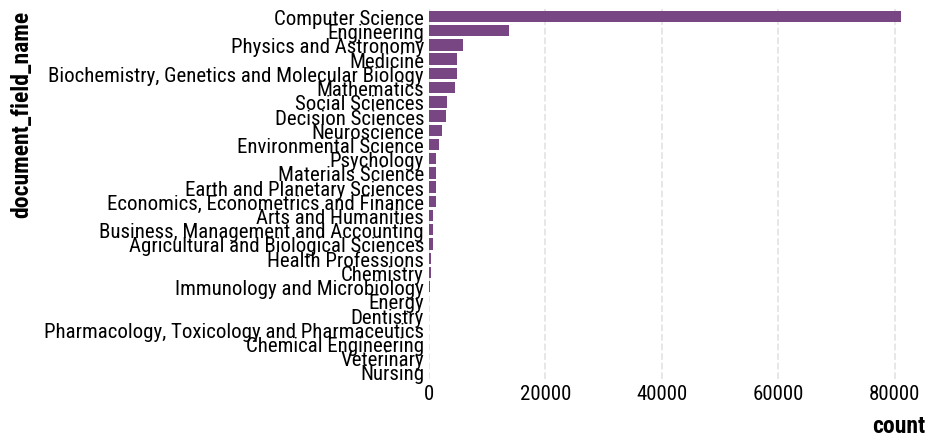

In [3]:
field_count_plot_data = pairs.filter(
    pl.col("document_field_name").is_not_null(),
    pl.col("document_field_name") != "",
)

print(field_count_plot_data["document_field_name"].value_counts(sort=True))

# Countplot of field
sns.countplot(
    data=field_count_plot_data,
    y="document_field_name",
    order=field_count_plot_data["document_field_name"].value_counts(sort=True)[
        "document_field_name"
    ],
)

In [4]:
# Get mean, std, 25th, 50th, 75th percentiles for selected fields
pairs[
    [
        "document_cited_by_count",
        "document_fwci",
        "document_n_authors",
        "repository_stargazers_count",
        "repository_fwsi",
        "repository_commits_count",
        "repository_n_contributors",
        "repository_n_files",
        "repository_n_languages",
        "repository_size_kb",
        "repository_commit_duration_days",
    ]
].describe(percentiles=[0.25, 0.5, 0.75]).filter(
    pl.col("statistic").is_in(["mean", "std", "25%", "50%", "75%"]),
).transpose(include_header=True, header_name="metric", column_names="statistic")

metric,mean,std,25%,50%,75%
str,f64,f64,f64,f64,f64
"""document_cited_by_count""",9.346711,109.728114,0.0,1.0,3.0
"""document_fwci""",2.148442,18.6871,0.0,0.338181,1.559658
"""document_n_authors""",4.93385,4.112452,3.0,4.0,6.0
"""repository_stargazers_count""",91.700908,1025.660811,2.0,8.0,31.0
"""repository_fwsi""",NaN,NaN,0.026795,0.110459,0.409758
…,…,…,…,…,…
"""repository_n_contributors""",1.98723,3.226225,1.0,1.0,2.0
"""repository_n_files""",404.945422,2815.007076,17.0,41.0,114.0
"""repository_n_languages""",2.31644,2.054771,1.0,2.0,3.0


/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_84263/176248484.py:108: UserWarning: The figure layout has changed to tight
  fig.tight_layout(h_pad=3.0)


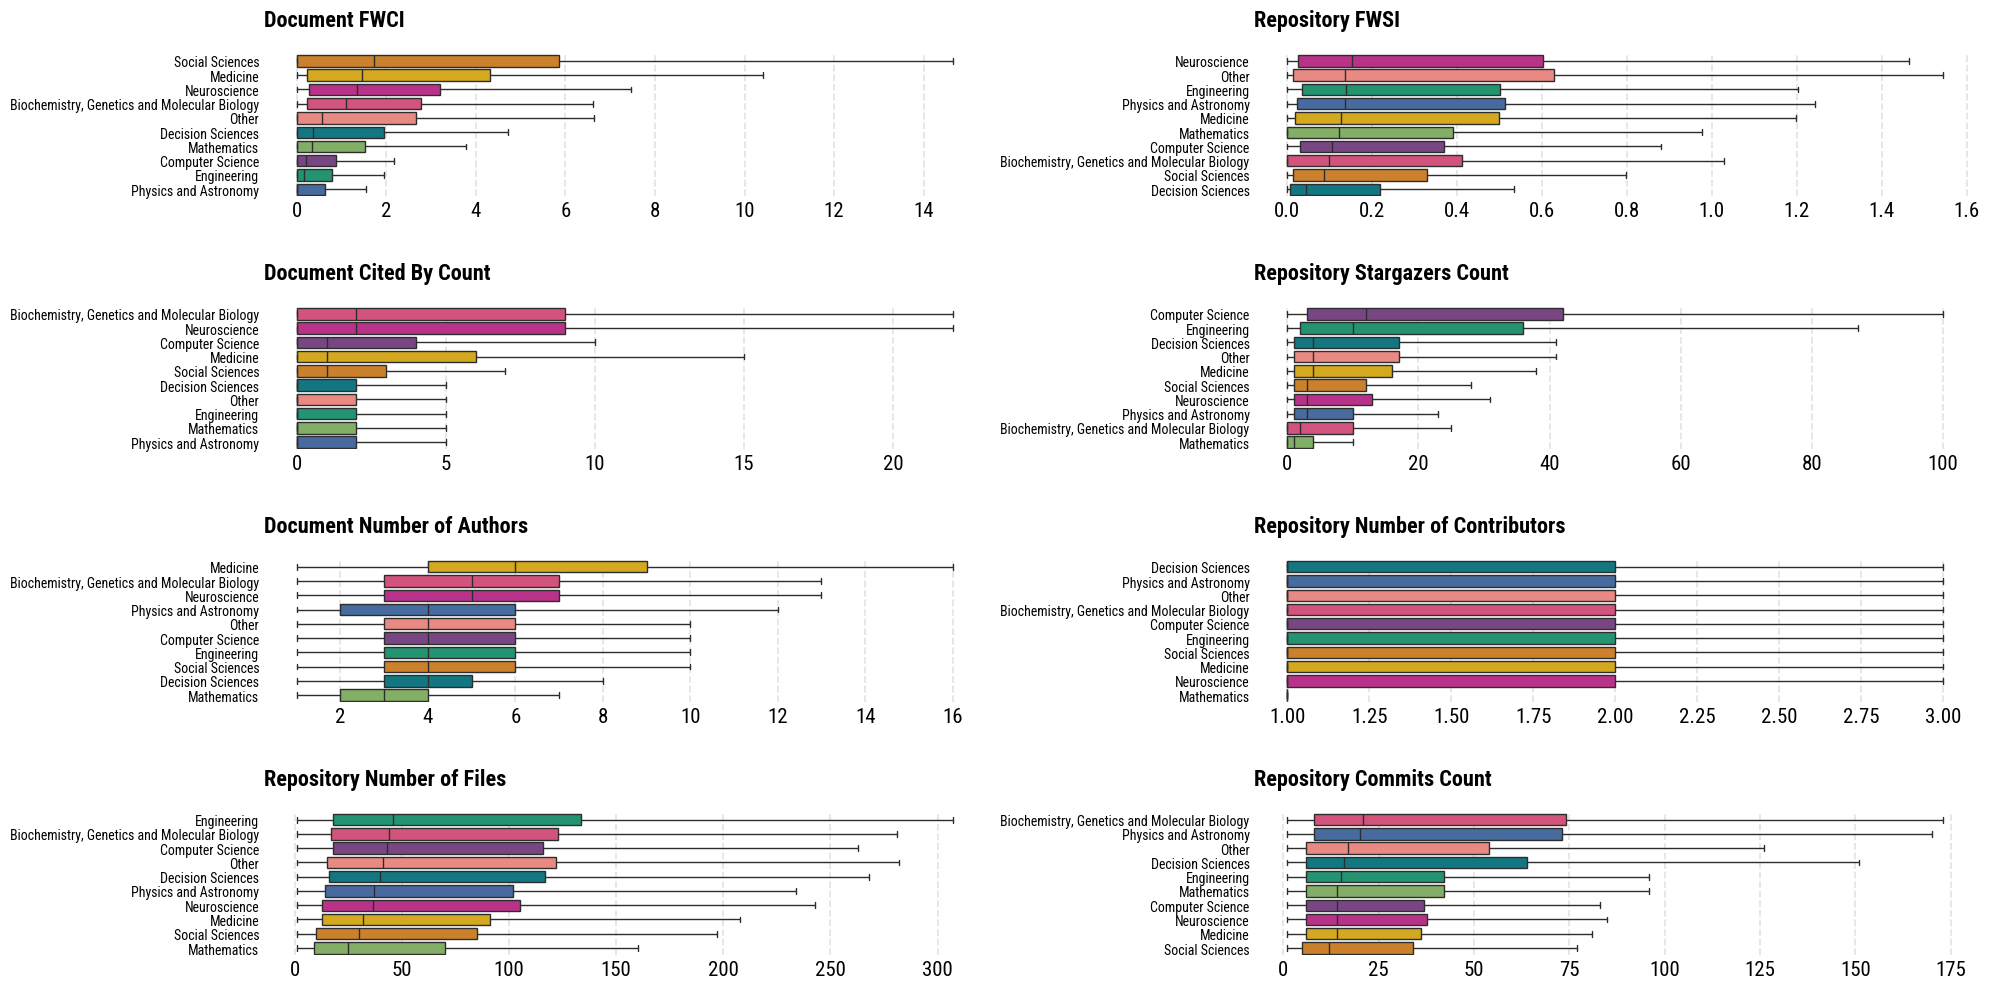

In [ ]:
# Plot features by top N fields + Other
top_nine_fields = (
    pairs.filter(
        pl.col("document_field_name").is_not_null(),
    )["document_field_name"]
    .value_counts(sort=True)
    .head(DEFAULT_TOP_N)["document_field_name"]
    .to_list()
)
pairs = pairs.with_columns(
    pl.when(pl.col("document_field_name").is_in(top_nine_fields))
    .then(pl.col("document_field_name"))
    .otherwise(pl.lit("Other"))
    .alias("document_field_name_top_nine_plus_other")
)

# Select features then unpivot for plotting
features_to_plot = [
    "document_fwci",
    "repository_fwsi",
    "document_cited_by_count",
    "repository_stargazers_count",
    "document_n_authors",
    "repository_n_contributors",
    "repository_n_files",
    "repository_commits_count",
]
features_melted = pairs.select(
    [
        "document_id",
        "repository_id",
        "document_field_name_top_nine_plus_other",
        *features_to_plot,
    ]
).unpivot(
    on=features_to_plot,
    variable_name="feature",
    value_name="value",
    index=["document_id", "repository_id", "document_field_name_top_nine_plus_other"],
)

FEATURE_NAME_TO_VIZ_NAME_LUT = {
    "document_fwci": "Document FWCI",
    "repository_fwsi": "Repository FWSI",
    "document_cited_by_count": "Document Cited By Count",
    "repository_stargazers_count": "Repository Stargazers Count",
    "document_n_authors": "Document Number of Authors",
    "repository_n_contributors": "Repository Number of Contributors",
    "repository_n_files": "Repository Number of Files",
    "repository_commits_count": "Repository Commits Count",
}

# Add a feature name sort value for consistent ordering
features_melted = features_melted.with_columns(
    pl.col("feature")
    .map_elements(
        lambda x: list(FEATURE_NAME_TO_VIZ_NAME_LUT.keys()).index(x),
        return_dtype=pl.Int32,
    )
    .alias("feature_sort_order")
)
features_melted = features_melted.sort("feature_sort_order").drop("feature_sort_order")

# Get consistant hue order across plots
field_hue_order = [*top_nine_fields, "Other"]

# Setup figure and axes
fig, axes = plt.subplots(
    nrows=4,
    ncols=2,
    figsize=(20, 10),
    constrained_layout=True,
)
for ax, ((feature_name,), group_df) in zip(
    axes.flat, features_melted.group_by("feature", maintain_order=True), strict=True
):
    # Determine order by median value
    y_order = (
        group_df.group_by("document_field_name_top_nine_plus_other")
        .agg(
            pl.col("value").median().alias("median_value"),
            pl.col("value").mean().alias("mean_value"),
        )
        .sort(
            ["median_value", "mean_value", "document_field_name_top_nine_plus_other"],
            descending=True,
        )["document_field_name_top_nine_plus_other"]
        .to_list()
    )

    sns.boxplot(
        data=group_df,
        y="document_field_name_top_nine_plus_other",
        x="value",
        hue="document_field_name_top_nine_plus_other",
        hue_order=field_hue_order,
        order=y_order,
        ax=ax,
        # cut=0,
        showfliers=False,
    )

    # Remove axis labels
    ax.set_ylabel("")
    ax.set_xlabel("")

    # Make y-axis tick labels smaller
    ax.tick_params(axis="y", labelsize=10)

    # Set title
    ax.set_title(FEATURE_NAME_TO_VIZ_NAME_LUT.get(feature_name, feature_name), fontsize=16)

    # Add single legend outside the plot
    # fig.legend(
    #     title="Document Field Name",
    #     labels=field_hue_order,
    #     loc="center left",
    #     bbox_to_anchor=(1, 0.5),
    #     fontsize=12,
    #     title_fontsize=14,
    # )

# Add more whitespace between subplots vertically
fig.tight_layout(h_pad=3.0)

/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_84263/2890056571.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


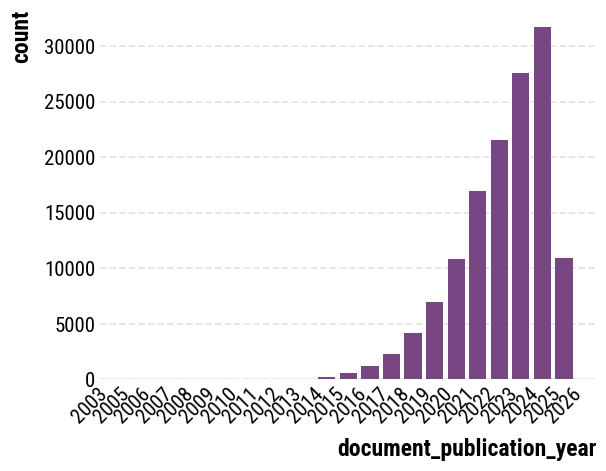

In [6]:
# Plot count of pairs over time
ax = sns.countplot(
    data=pairs,
    x="document_publication_year",
)

# Rotate x-axis labels for readability
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_84263/2753748150.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_84263/2753748150.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_84263/2753748150.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_84263/2753748150.py:84: UserWarning: set_ticklabels() should only be used with a fixed numbe

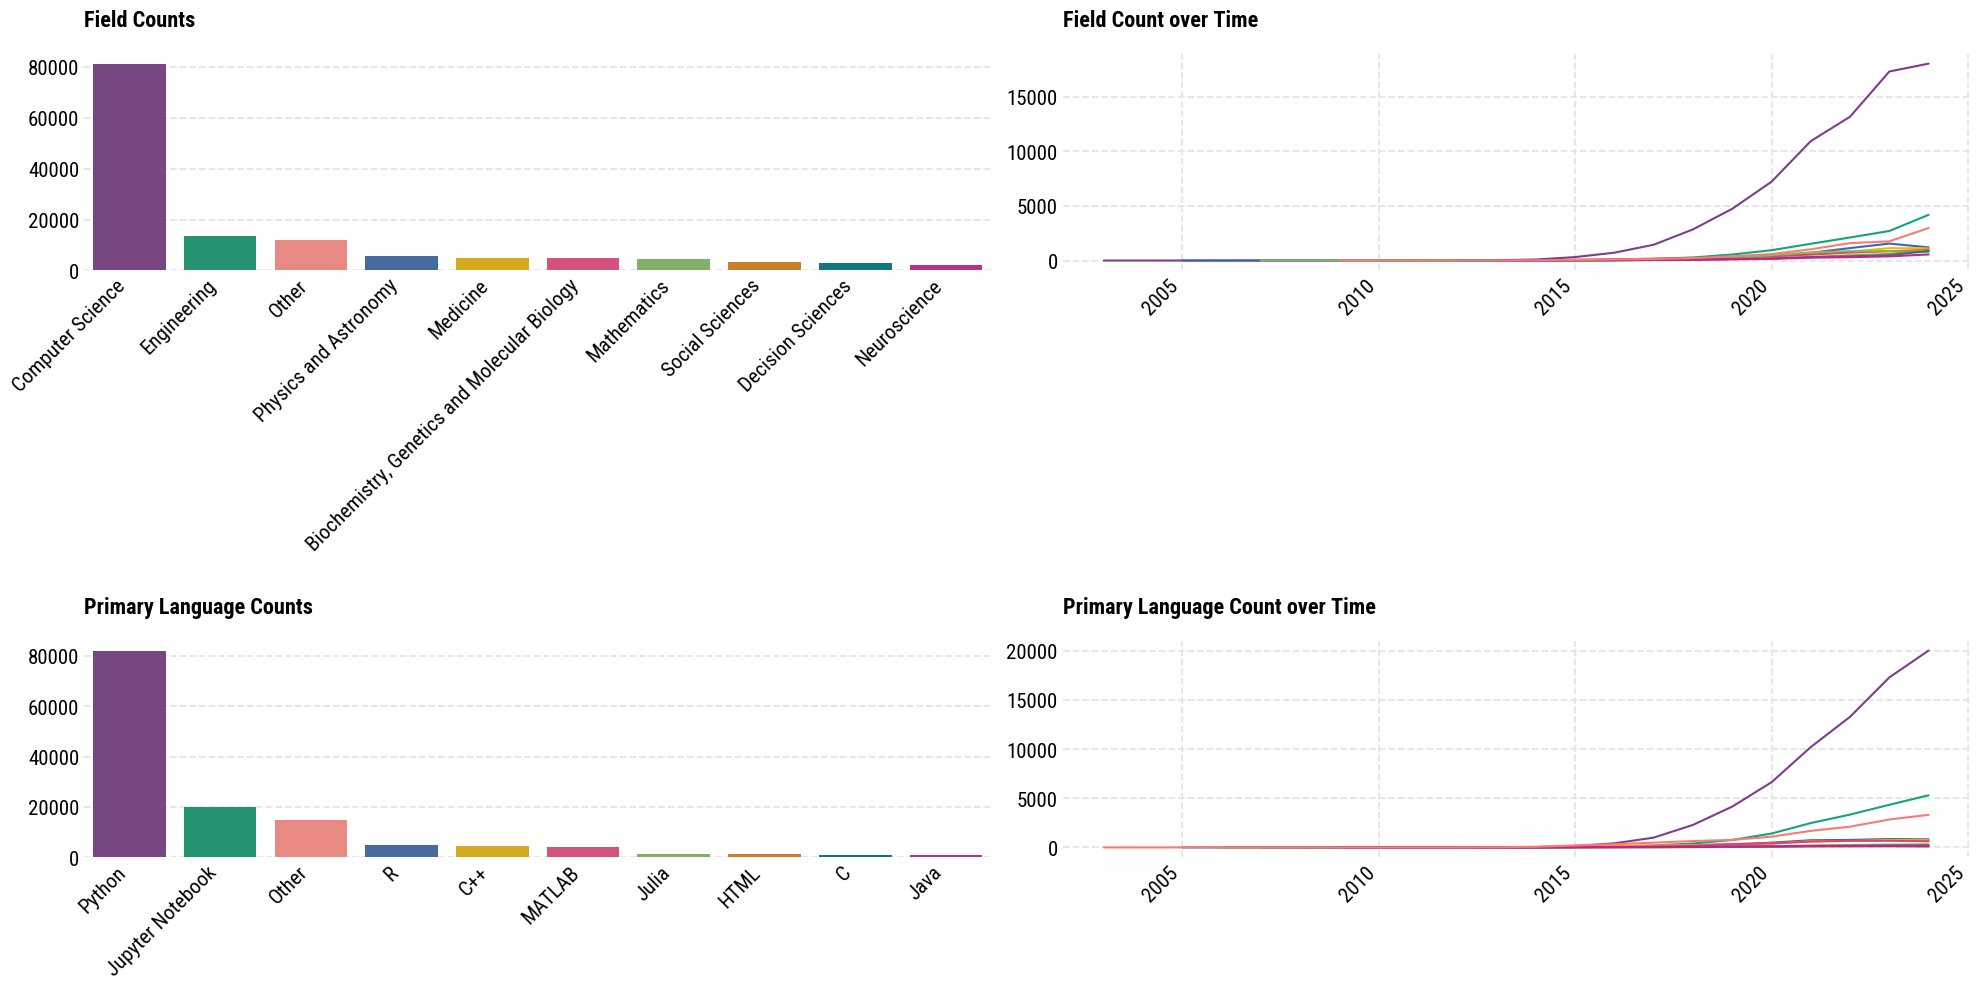

In [ ]:
# We want to plot two features normally: field name, primary language
# Then we want to also plot the top 9 fields + other over time
# And, we want to plot the top 9 primary languages + other over time

# Easiest method for doing this is probably fig axes and then add each plot individually
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(20, 10),
    constrained_layout=True,
)

feature_to_title_lut = {
    "document_field_name_top_nine_plus_other": "Field Counts",
    "field_count": "Field Count over Time",
    "repository_primary_language_top_nine_plus_other": "Primary Language Counts",
    "language_count": "Primary Language Count over Time",
}

# Field name normal
sns.countplot(
    data=pairs,
    x="document_field_name_top_nine_plus_other",
    order=pairs["document_field_name_top_nine_plus_other"].value_counts(sort=True)[
        "document_field_name_top_nine_plus_other"
    ],
    hue="document_field_name_top_nine_plus_other",
    hue_order=field_hue_order,
    ax=axes[0, 0],
)

# Field name over time
sns.lineplot(
    data=pairs.group_by(
        ["document_field_name_top_nine_plus_other", "document_publication_year"]
    )
    .agg(pl.len().alias("field_count"))
    .filter(
        pl.col("document_publication_year") < 2025,
    ),
    x="document_publication_year",
    y="field_count",
    hue="document_field_name_top_nine_plus_other",
    hue_order=field_hue_order,
    ax=axes[0, 1],
    legend=False,
)

# Add column for top N primary languages + other
top_nine_languages = (
    pairs.filter(pl.col("repository_primary_language").is_not_null())[
        "repository_primary_language"
    ]
    .value_counts(sort=True)
    .head(DEFAULT_TOP_N)["repository_primary_language"]
    .to_list()
)
top_nine_languages_hue_order = [*top_nine_languages, "Other"]
pairs = pairs.with_columns(
    pl.when(pl.col("repository_primary_language").is_in(top_nine_languages))
    .then(pl.col("repository_primary_language"))
    .otherwise(pl.lit("Other"))
    .alias("repository_primary_language_top_nine_plus_other")
)

# Primary language normal
sns.countplot(
    data=pairs,
    x="repository_primary_language_top_nine_plus_other",
    order=pairs["repository_primary_language_top_nine_plus_other"].value_counts(sort=True)[
        "repository_primary_language_top_nine_plus_other"
    ],
    hue="repository_primary_language_top_nine_plus_other",
    hue_order=top_nine_languages_hue_order,
    ax=axes[1, 0],
)

# Primary language over time
sns.lineplot(
    data=pairs.group_by(
        ["repository_primary_language_top_nine_plus_other", "document_publication_year"]
    )
    .agg(pl.len().alias("language_count"))
    .filter(
        pl.col("document_publication_year") < 2025,
    ),
    x="document_publication_year",
    y="language_count",
    hue="repository_primary_language_top_nine_plus_other",
    hue_order=top_nine_languages_hue_order,
    ax=axes[1, 1],
    legend=False,
)

for ax in axes.flat:
    # Rotate all x-tick labels for readability
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    # Remove axis labels
    feature_name = ax.get_xlabel()
    feature_name = (
        ax.get_ylabel() if feature_name == "document_publication_year" else feature_name
    )
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Set title
    ax.set_title(feature_to_title_lut.get(feature_name, feature_name), fontsize=16)

fig.tight_layout(h_pad=3.0)

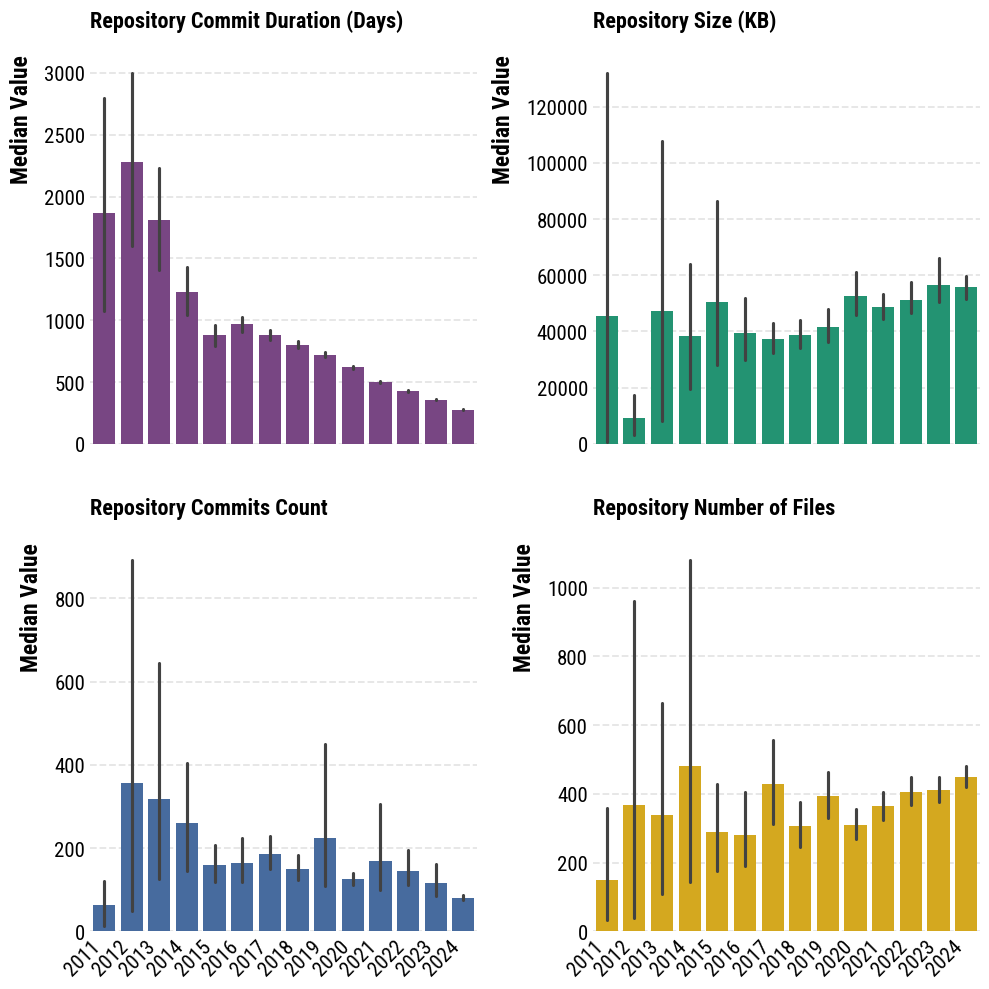

In [8]:
# Plot median repository commit duration, size, commits, and number of files over time
over_time_metrics = [
    "repository_commit_duration_days",
    "repository_size_kb",
    "repository_commits_count",
    "repository_n_files",
]

over_time_metrics_to_viz_name_lut = {
    "repository_commit_duration_days": "Repository Commit Duration (Days)",
    "repository_size_kb": "Repository Size (KB)",
    "repository_commits_count": "Repository Commits Count",
    "repository_n_files": "Repository Number of Files",
}

over_time_df = pairs.filter(
    pl.col("document_publication_year") < 2025,
    pl.col("document_publication_year") > 2010,
)

over_time_df = over_time_df.unpivot(
    on=over_time_metrics,
    variable_name="metric",
    value_name="median_value",
    index=["document_publication_year"],
)

g = sns.catplot(
    data=over_time_df,
    x="document_publication_year",
    y="median_value",
    hue="metric",
    col="metric",
    col_wrap=2,
    kind="bar",
    # facet_kws={"sharey": False},
    sharey=False,
    legend=False,
)

# Set titles and labels
g.set_titles("{col_name}")

# Rotate x-axis labels for readability
for i, ax in enumerate(g.axes):
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")
    ax.set_xlabel("")
    ax.set_ylabel("Median Value")
    ax.set_title(over_time_metrics_to_viz_name_lut.get(over_time_metrics[i]), fontsize=16)

g.figure.tight_layout(h_pad=3.0)

## FWCI vs FWSI

shape: (2, 4)
┌─────────────────────┬─────────────────────────────────┬──────────────────┬─────────────────┐
│ document_fwci_log10 ┆ document_title                  ┆ repository_owner ┆ repository_name │
│ ---                 ┆ ---                             ┆ ---              ┆ ---             │
│ f64                 ┆ str                             ┆ str              ┆ str             │
╞═════════════════════╪═════════════════════════════════╪══════════════════╪═════════════════╡
│ 3.420799            ┆ Welcome to the Tidyverse        ┆ tidyverse        ┆ tidyverse       │
│ 3.033674            ┆ Persona-Driven Benchmarking fo… ┆ ysymyth          ┆ react           │
└─────────────────────┴─────────────────────────────────┴──────────────────┴─────────────────┘
shape: (2, 4)
┌───────────────────────┬─────────────────────────────────┬──────────────────┬─────────────────┐
│ repository_fwsi_log10 ┆ document_title                  ┆ repository_owner ┆ repository_name │
│ ---             

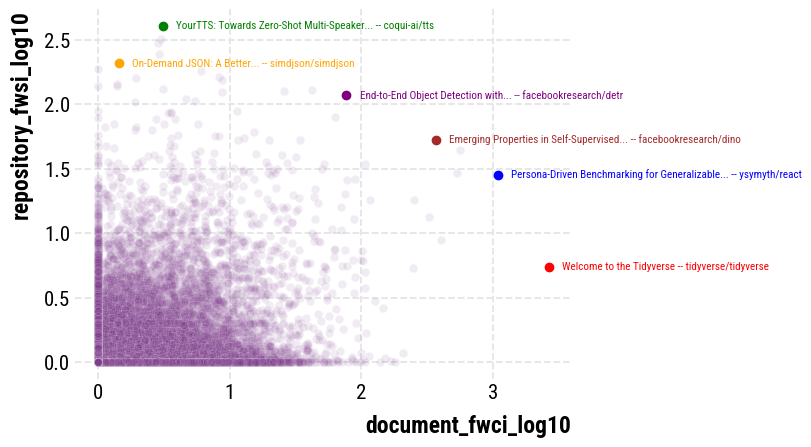

In [9]:
# FWCI vs FWSI scatter plot with top points labeled
fwci_fwsi_plot_data = (
    pairs.filter(
        pl.col("document_fwci").is_not_null(),
        pl.col("repository_fwsi").is_not_null(),
        pl.col("document_fwci").is_not_nan(),
        pl.col("repository_fwsi").is_not_nan(),
        pl.col("document_fwci").is_finite(),
        pl.col("repository_fwsi").is_finite(),
    )
    .with_columns(
        (pl.lit(1) + pl.col("document_fwci")).log10().alias("document_fwci_log10"),
        (pl.lit(1) + pl.col("repository_fwsi")).log10().alias("repository_fwsi_log10"),
    )
    .filter(
        pl.col("document_fwci_log10").is_not_null(),
        pl.col("repository_fwsi_log10").is_not_null(),
        pl.col("document_fwci_log10").is_not_nan(),
        pl.col("repository_fwsi_log10").is_not_nan(),
        pl.col("document_fwci_log10").is_finite(),
        pl.col("repository_fwsi_log10").is_finite(),
    )
)

fwci_fwsi_ax = sns.scatterplot(
    data=fwci_fwsi_plot_data,
    x="document_fwci_log10",
    y="repository_fwsi_log10",
    alpha=0.1,
)


def _plot_fwci_fwsi_point_data(row: dict, color: str, ax: plt.Axes) -> None:
    doc_title_parts = row["document_title"].split()
    doc_title_short = (
        " ".join(doc_title_parts[:4]) + "..."
        if len(doc_title_parts) > 4
        else row["document_title"]
    )
    point_label = f"{doc_title_short} -- {row['repository_owner']}/{row['repository_name']}"
    ax.text(
        row["document_fwci_log10"] + 0.1,
        row["repository_fwsi_log10"] - 0.02,
        point_label,
        fontsize=8,
        color=color,
    )
    ax.plot(
        row["document_fwci_log10"],
        row["repository_fwsi_log10"],
        "o",
        color=color,
    )


# Label the top two points by document FWCI
top_fwci_points = fwci_fwsi_plot_data.sort("document_fwci_log10", descending=True).head(2)
print(
    top_fwci_points[
        [
            "document_fwci_log10",
            "document_title",
            "repository_owner",
            "repository_name",
        ]
    ]
)
colors = ["red", "blue"]
for row in top_fwci_points.iter_rows(named=True):
    _plot_fwci_fwsi_point_data(row, colors.pop(0), fwci_fwsi_ax)

# Label the top two points by repository FWSI
top_fwsi_points = fwci_fwsi_plot_data.sort("repository_fwsi_log10", descending=True)[[0, 4]]
print(
    top_fwsi_points[
        [
            "repository_fwsi_log10",
            "document_title",
            "repository_owner",
            "repository_name",
        ]
    ]
)
colors = ["green", "orange"]
for row in top_fwsi_points.iter_rows(named=True):
    _plot_fwci_fwsi_point_data(row, colors.pop(0), fwci_fwsi_ax)


# Find a repo with high product of FWCI and FWSI
fwci_fwsi_plot_data = fwci_fwsi_plot_data.with_columns(
    (pl.col("document_fwci_log10") * pl.col("repository_fwsi_log10")).alias(
        "fwci_fwsi_product_log10"
    )
)
selected_fwci_fwsi_points = fwci_fwsi_plot_data.sort(
    "fwci_fwsi_product_log10", descending=True
)[[1, 4]]
print(
    selected_fwci_fwsi_points[
        [
            "fwci_fwsi_product_log10",
            "document_title",
            "repository_owner",
            "repository_name",
        ]
    ]
)
colors = ["brown", "purple"]
for row in selected_fwci_fwsi_points.iter_rows(named=True):
    _plot_fwci_fwsi_point_data(row, colors.pop(0), fwci_fwsi_ax)

# Find the point that is closest to 1 FWCI and 1 FWSI
# fwci_fwsi_plot_data = fwci_fwsi_plot_data.with_columns(
#     (pl.col("document_fwci") * pl.col("repository_fwsi") - pl.lit(1)).abs().alias("distance_to_one_one")
# )
# closest_point = fwci_fwsi_plot_data.sort("distance_to_one_one").head(1)
# print(closest_point[[
#     "document_title",
#     "repository_owner",
#     "repository_name",
# ]])
# _plot_fwci_fwsi_point_data(
#     closest_point.row(0, named=True),
#     "black",
#     fwci_fwsi_ax,
# )

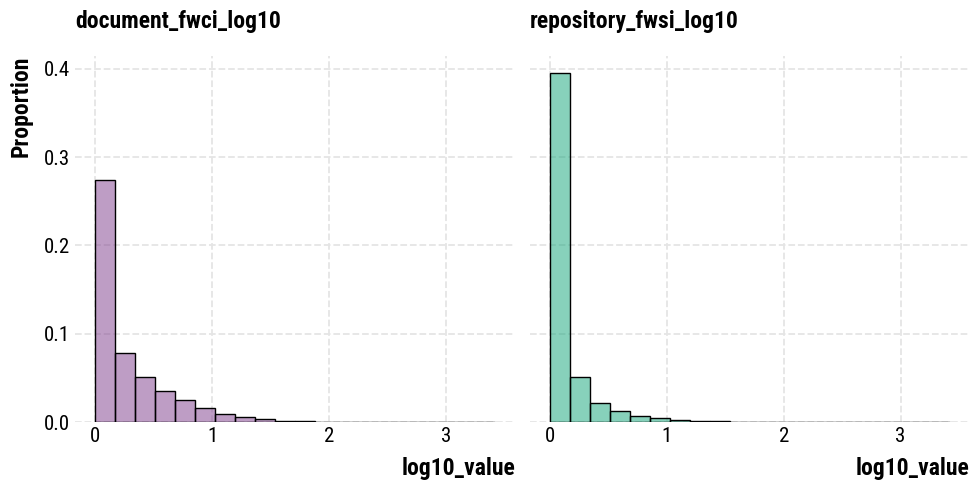

In [10]:
# Unpivot the plot data to only include doc id, repo id, fwci_log10, fwsi_log10
fwci_fwsi_plot_data_melted = fwci_fwsi_plot_data.select(
    [
        "document_id",
        "repository_id",
        "document_fwci_log10",
        "repository_fwsi_log10",
    ]
).unpivot(
    on=["document_fwci_log10", "repository_fwsi_log10"],
    index=["document_id", "repository_id"],
    variable_name="metric",
    value_name="log10_value",
)

# Plot the distribution of FWCI and FWSI log10 values
g = sns.displot(
    data=fwci_fwsi_plot_data_melted,
    x="log10_value",
    hue="metric",
    col="metric",
    bins=20,
    stat="proportion",
    legend=False,
)

# Update the subplot titles
g.set_titles("{col_name}")

## Date Relationships

/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_84263/1446344104.py:79: UserWarning: The figure layout has changed to tight
  fig.tight_layout(w_pad=3.0)


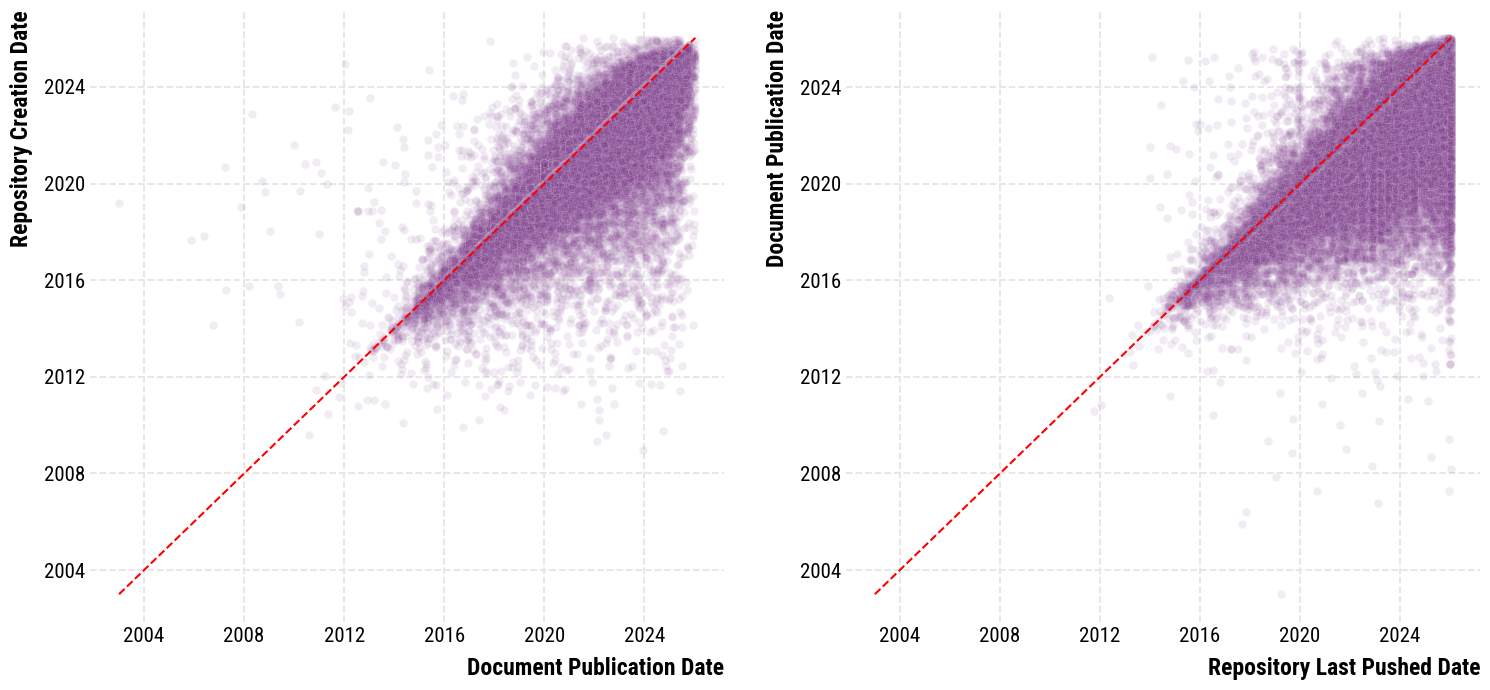

In [11]:
# Two plots, one for repo creation vs publication date and one for publication date vs most recent push date
date_relationships_df = pairs.select(
    [
        "document_publication_date",
        "repository_creation_datetime",
        "repository_last_pushed_datetime",
    ]
)

# Create fig axes for 2 plots
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15, 7),
    constrained_layout=True,
)

sns.scatterplot(
    data=date_relationships_df,
    x="document_publication_date",
    y="repository_creation_datetime",
    alpha=0.1,
    ax=axes[0],
)

# Add 45 degree line
min_date = min(
    date_relationships_df["document_publication_date"].min(),
    date_relationships_df["repository_creation_datetime"].dt.date().min(),
)
max_date = max(
    date_relationships_df["document_publication_date"].max(),
    date_relationships_df["repository_creation_datetime"].dt.date().max(),
)
_ = axes[0].plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
)

sns.scatterplot(
    data=date_relationships_df,
    x="repository_last_pushed_datetime",
    y="document_publication_date",
    alpha=0.1,
    ax=axes[1],
)
axes[1].invert_yaxis()

# Add 45 degree line
min_date = min(
    date_relationships_df["document_publication_date"].min(),
    date_relationships_df["repository_last_pushed_datetime"].dt.date().min(),
)
max_date = max(
    date_relationships_df["document_publication_date"].max(),
    date_relationships_df["repository_last_pushed_datetime"].dt.date().max(),
)
_ = axes[1].plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
)

features_to_viz_name_lut = {
    "repository_creation_datetime": "Repository Creation Date",
    "document_publication_date": "Document Publication Date",
    "repository_last_pushed_datetime": "Repository Last Pushed Date",
}

for ax in axes.flat:
    # Remove axis labels
    x_label = ax.get_xlabel()
    y_label = ax.get_ylabel()
    ax.set_xlabel(features_to_viz_name_lut.get(x_label, x_label))
    ax.set_ylabel(features_to_viz_name_lut.get(y_label, y_label))

# Tighten layout
fig.tight_layout(w_pad=3.0)

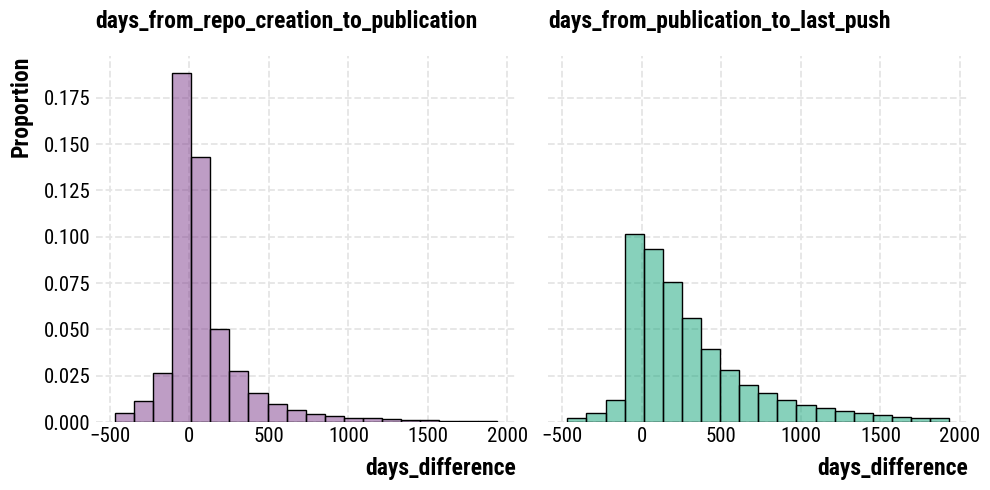

In [12]:
# Create the same plot but as distribution of "Days from X to Y"
date_relationships_days_df = (
    date_relationships_df.with_columns(
        (
            (
                pl.col("document_publication_date") - pl.col("repository_creation_datetime")
            ).dt.total_days()
        ).alias("days_from_repo_creation_to_publication"),
        (
            (
                pl.col("repository_last_pushed_datetime") - pl.col("document_publication_date")
            ).dt.total_days()
        ).alias("days_from_publication_to_last_push"),
    )
    .select(
        [
            "days_from_repo_creation_to_publication",
            "days_from_publication_to_last_push",
        ]
    )
    .unpivot(
        on=[
            "days_from_repo_creation_to_publication",
            "days_from_publication_to_last_push",
        ],
        index=[],
        variable_name="date_difference_type",
        value_name="days_difference",
    )
)

g = sns.displot(
    data=date_relationships_days_df.filter(
        pl.col("days_difference")
        > date_relationships_days_df["days_difference"].quantile(0.01),
        pl.col("days_difference")
        < date_relationships_days_df["days_difference"].quantile(0.99),
    ),
    x="days_difference",
    hue="date_difference_type",
    col="date_difference_type",
    bins=20,
    stat="proportion",
    legend=False,
)

g.set_titles("{col_name}")

## Network Coverage

In [ ]:
def build_coauthorship_network(
    df: pl.DataFrame, sample_size: int | None = None
) -> tuple[rx.PyGraph, dict[int, int], dict[int, int], pl.DataFrame]:
    """Build a co-authorship network from document contributors using rustworkx.

    Returns:
        Tuple of (graph, node_to_idx mapping, idx_to_node mapping, doc contribs DataFrame).
    """
    doc_contribs = _read_table("document_contributor")

    # Filter to documents in our dataset
    doc_ids_in_dataset = df["document_id"].unique().to_list()
    doc_contribs = doc_contribs.filter(pl.col("document_id").is_in(doc_ids_in_dataset))

    # Apply sampling if requested
    if sample_size is not None:
        sampled_doc_ids = (
            doc_contribs.select("document_id")
            .unique()
            .sample(n=min(sample_size, len(doc_ids_in_dataset)), seed=42)
        )
        doc_contribs = doc_contribs.filter(
            pl.col("document_id").is_in(sampled_doc_ids["document_id"])
        )

    # Build rustworkx graph
    coauthorship_graph = rx.PyGraph()
    node_to_idx: dict[int, int] = {}  # researcher_id -> rustworkx node index
    idx_to_node: dict[int, int] = {}  # rustworkx node index -> researcher_id

    # Add nodes and edges
    for _, group in tqdm(
        doc_contribs.group_by("document_id"),
        total=doc_contribs["document_id"].n_unique(),
        desc="Building co-authorship network",
    ):
        # Add nodes for all authors
        for author in group.iter_rows(named=True):
            this_author_researcher_id = author["researcher_id"]
            if this_author_researcher_id not in node_to_idx:
                rx_node_idx = coauthorship_graph.add_node(this_author_researcher_id)
                node_to_idx[this_author_researcher_id] = rx_node_idx
                idx_to_node[rx_node_idx] = this_author_researcher_id

        # Add edges between co-authors
        for a1 in group.iter_rows(named=True):
            author_one_researcher_id = a1["researcher_id"]
            for a2 in group.iter_rows(named=True):
                author_two_researcher_id = a2["researcher_id"]
                if author_one_researcher_id == author_two_researcher_id:
                    continue

                # Add edge
                # Lookup node indices
                node_idx_1 = node_to_idx[author_one_researcher_id]
                node_idx_2 = node_to_idx[author_two_researcher_id]
                coauthorship_graph.add_edge(node_idx_1, node_idx_2, 1)

    print("Network built:")
    print(f"Nodes (authors): {coauthorship_graph.num_nodes():,}")
    print(f"Edges (co-authorships): {coauthorship_graph.num_edges():,}")

    return coauthorship_graph, node_to_idx, idx_to_node, doc_contribs


coauthorship_graph, node_to_idx, idx_to_node, doc_contribs = build_coauthorship_network(pairs)

Building co-authorship network: 100%|██████████| 135072/135072 [00:16<00:00, 8274.58it/s]

Network built:
Nodes (authors): 302,980
Edges (co-authorships): 3,864,982


In [14]:
components = rx.connected_components(coauthorship_graph)
component_sizes = sorted([len(c) for c in components], reverse=True)

total_nodes = coauthorship_graph.num_nodes()
largest_component_size = component_sizes[0] if component_sizes else 0
coverage = largest_component_size / total_nodes if total_nodes > 0 else 0

print(f"\nTotal number of components: {len(components):,}")
print(f"Total authors (nodes): {total_nodes:,}")
print(f"Largest component size: {largest_component_size:,}")
print(f"Coverage (largest / total): {coverage:.2%}")

print("\nComponent size distribution:")
print(f"  Largest 5: {component_sizes[:5]}")
print(f"  Isolates (size 1): {component_sizes.count(1):,}")
print(f"  Size 2-10: {sum(1 for s in component_sizes if 2 <= s <= 10):,}")
print(f"  Size 11-100: {sum(1 for s in component_sizes if 11 <= s <= 100):,}")
print(f"  Size >100: {sum(1 for s in component_sizes if s > 100):,}")


Total number of components: 16,010
Total authors (nodes): 302,980
Largest component size: 242,343
Coverage (largest / total): 79.99%

Component size distribution:
  Largest 5: [242343, 75, 64, 43, 40]
  Isolates (size 1): 3,098
  Size 2-10: 12,257
  Size 11-100: 654
  Size >100: 1


In [15]:
# Get the largest connected component
largest_cc = max(components, key=len)

# Get the list of node indices in the largest component
largest_cc_nodes = list(largest_cc)

# Create subgraph for largest component
coauthorship_graph_largest_component = coauthorship_graph.subgraph(largest_cc_nodes)

print("\nAnalyzing largest connected component:")
print(f"  Nodes: {coauthorship_graph_largest_component.num_nodes():,}")
print(f"  Edges: {coauthorship_graph_largest_component.num_edges():,}")

# Create mapping from original indices to subgraph indices
# The subgraph nodes are reindexed 0, 1, 2, ... in the order they appear in largest_cc_nodes
original_to_subgraph = {orig_idx: new_idx for new_idx, orig_idx in enumerate(largest_cc_nodes)}

# Sample nodes for path length calculation
actual_sample_size = min(5_000, len(largest_cc_nodes))

if len(largest_cc_nodes) > actual_sample_size:
    sampled_original_indices = (
        pl.Series(largest_cc_nodes).sample(n=actual_sample_size, seed=42).to_list()
    )
    print(f"  Sampling {actual_sample_size:,} nodes for path analysis")
else:
    sampled_original_indices = largest_cc_nodes

# Convert to subgraph indices
sampled_subgraph_indices = [original_to_subgraph[idx] for idx in sampled_original_indices]

# Calculate shortest paths using rustworkx
path_lengths = []
for source_idx in tqdm(sampled_subgraph_indices, desc="Computing shortest paths"):
    for target_idx in sampled_subgraph_indices:
        if source_idx == target_idx:
            continue

        # Get length of shortest path
        lengths_dict = rx.dijkstra_shortest_path_lengths(
            coauthorship_graph_largest_component, source_idx, lambda _: 1, goal=target_idx
        )

        # dijkstra_shortest_path_lengths returns a dict {node: distance}
        if target_idx in lengths_dict:
            path_lengths.append(lengths_dict[target_idx])

path_lengths = np.array(path_lengths)

print("\nShortest path statistics:")
print(f"  Pairs analyzed: {len(path_lengths):,}")
print(f"  Average path length: {np.mean(path_lengths):.2f}")
print(f"  Median path length: {np.median(path_lengths):.0f}")
print(f"  Min: {np.min(path_lengths)}, Max: {np.max(path_lengths)}")


Analyzing largest connected component:
  Nodes: 242,343
  Edges: 3,602,448
  Sampling 5,000 nodes for path analysis


Computing shortest paths:   0%|          | 0/5000 [02:24<?, ?it/s]


KeyboardInterrupt: 